In [ ]:
!pip install torch-geometric

#Import Libraries

In [ ]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Config

In [ ]:
class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 165
    output_dim = 1
    hidden_size = 128
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", Config.device)

Using device: cuda


#Preprocessing


In [ ]:
df_classes = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/FYP/data/elliptic_txs_classes.csv')
df_features = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/FYP/data/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/FYP/data/elliptic_txs_edgelist.csv')
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})


In [ ]:
# here column 0 stands for node_id, column 1 is the time axis
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [ ]:
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


0 - legitimate<br>
1 - fraud<br>
2 - unknown class<br>

In [ ]:
df_classes['class'].value_counts()

class
2    157205
0     42019
1      4545
Name: count, dtype: int64

In [ ]:
# merging node features DF with classes DF
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)# extracting classified/non-classified nodes
classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# extracting classified/non-classified edges
classified_edges = df_edges.loc[df_edges['txId1'].isin(classified[0]) & df_edges['txId2'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['txId1'].isin(unclassified[0]) | df_edges['txId2'].isin(unclassified[0])]

In [ ]:
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


# Preparing edges

In [ ]:
# mapping nodes to indices
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# mapping edges to indices
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 234355])


# Preparing nodes

In [ ]:
# maping node ids to corresponding indexes
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# drop indeces, class and temporal axes
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

# PyG Dataset

In [ ]:
# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


In [ ]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx],
                     y_train,
                     classified_idx,
                     test_size=0.15,
                     random_state=Config.seed,
                     stratify=y_train)

In [ ]:
elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


# Models

In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()

        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.6)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, concat=False, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

# Train/test

In [ ]:
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

# Train GCN

In [ ]:
gcn_model = GCN(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)
data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_evaluate(gcn_model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

Epoch   0 | Train Loss: 1.276 | Train Acc:  41.67% | Val Loss: 1.24 | Val Acc: 43.15%
Saving model for best loss
Epoch  10 | Train Loss: 0.383 | Train Acc:  80.97% | Val Loss: 0.38 | Val Acc: 80.34%
Saving model for best loss
Epoch  20 | Train Loss: 0.287 | Train Acc:  87.76% | Val Loss: 0.28 | Val Acc: 87.73%
Saving model for best loss
Epoch  30 | Train Loss: 0.262 | Train Acc:  89.63% | Val Loss: 0.26 | Val Acc: 89.59%
Saving model for best loss
Epoch  40 | Train Loss: 0.253 | Train Acc:  90.22% | Val Loss: 0.25 | Val Acc: 90.48%
Saving model for best loss
Epoch  50 | Train Loss: 0.240 | Train Acc:  90.79% | Val Loss: 0.24 | Val Acc: 90.89%
Saving model for best loss
Epoch  60 | Train Loss: 0.235 | Train Acc:  90.98% | Val Loss: 0.23 | Val Acc: 91.14%
Saving model for best loss
Epoch  70 | Train Loss: 0.226 | Train Acc:  91.56% | Val Loss: 0.23 | Val Acc: 91.51%
Epoch  80 | Train Loss: 0.220 | Train Acc:  91.88% | Val Loss: 0.22 | Val Acc: 91.95%
Saving model for best loss
Epoch  90 

GCN(
  (gcn1): GCNConv(165, 128)
  (gcn2): GCNConv(128, 1)
)

# Test GCN

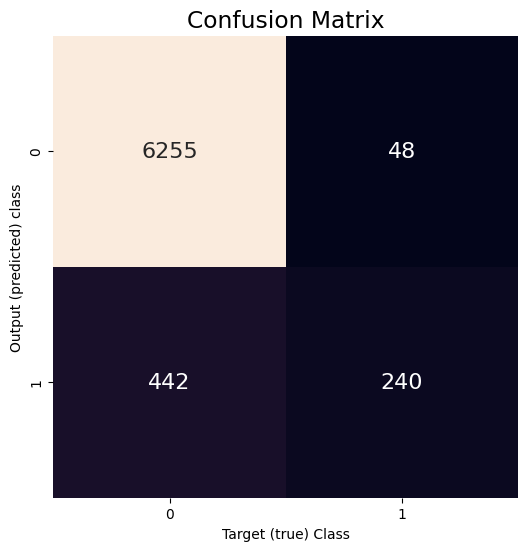

              precision    recall  f1-score   support

       licit       0.93      0.99      0.96      6303
     illicit       0.83      0.35      0.49       682

    accuracy                           0.93      6985
   macro avg       0.88      0.67      0.73      6985
weighted avg       0.92      0.93      0.92      6985

Test data fraud cases, percentage: 5.353519290098915 %


In [ ]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].detach().cpu().numpy()) # Move y_test_preds to CPU

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].detach().cpu().numpy(), # Move y_test_preds to CPU
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100} %")

# Train GAT

In [ ]:
gat_model = GAT(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)
data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gat_model,
               data_train,
               criterion,
               optimizer,
               Config.num_epochs,
               Config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 1.148 | Train Acc:  66.29% | Val Loss: 1.11 | Val Acc: 65.48%
Saving model for best loss
Epoch  10 | Train Loss: 0.540 | Train Acc:  88.31% | Val Loss: 0.52 | Val Acc: 87.54%
Saving model for best loss
Epoch  20 | Train Loss: 0.497 | Train Acc:  89.87% | Val Loss: 0.50 | Val Acc: 89.79%
Saving model for best loss
Epoch  30 | Train Loss: 0.476 | Train Acc:  89.70% | Val Loss: 0.53 | Val Acc: 89.66%
Epoch  40 | Train Loss: 0.464 | Train Acc:  89.89% | Val Loss: 0.48 | Val Acc: 90.15%
Saving model for best loss
Epoch  50 | Train Loss: 0.453 | Train Acc:  89.91% | Val Loss: 0.43 | Val Acc: 89.91%
Saving model for best loss
Epoch  60 | Train Loss: 0.451 | Train Acc:  90.08% | Val Loss: 0.44 | Val Acc: 90.11%
Epoch  70 | Train Loss: 0.440 | Train Acc:  90.43% | Val Loss: 0.45 | Val Acc: 90.24%
Epoch  80 | Train Loss: 0.431 | Train Acc:  90.49% | Val Loss: 0.45 | Val Acc: 89.98%
Epoch  90 | Train Loss: 0.431 | Train Acc:  90.41% | Val Loss: 0.42 | Val Acc: 90.18%
Savin

GAT(
  (gat1): GATv2Conv(165, 128, heads=8)
  (gat2): GATv2Conv(1024, 1, heads=1)
)

# Test GAT

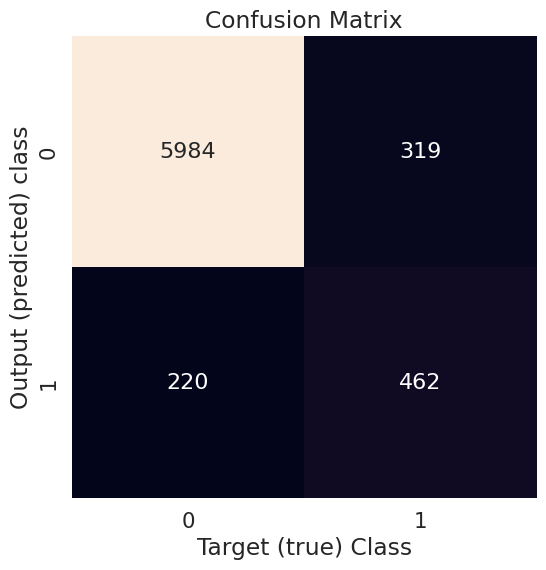

              precision    recall  f1-score   support

       licit       0.96      0.95      0.96      6303
     illicit       0.59      0.68      0.63       682

    accuracy                           0.92      6985
   macro avg       0.78      0.81      0.79      6985
weighted avg       0.93      0.92      0.93      6985

Test data fraud cases, percentage: 24.40062338984129 %


In [ ]:
gat_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
# Move y_test_preds to CPU before passing to confusion_matrix
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].detach().cpu().numpy())

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].detach().cpu().numpy(), # Move y_test_preds to CPU
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100} %")